# Bag of Visual Words 구현하기

[Bag-of-Visual-Words 이해하기](https://gjustin40.github.io/computervision/2019/08/26/Bag-of-Visual-Words-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0.html)
- Opencv를 이용해 descriptor 사용
- Sklearn을 이용해 Clustering 및 시각화
- KMeans과 PCA 알고리즘 사용

**<U>특허 문제로 SIFT 알고리즘 사용이 불가하여 BRISK 알고리즘으로 대체<U>**

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(cv2.__version__)
print(np.__version__)

%matplotlib inline

4.1.0
1.15.4


# 예시(1개 이미지 적용)

Img Shape :  (685, 960)


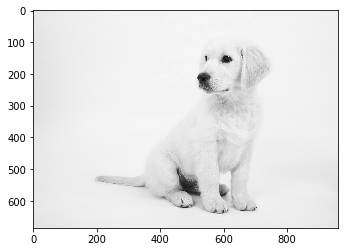

In [2]:
###### 이미지 열기
# gray scale로 변환

img_path = 'data/image/example_dog.jpg'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # RGB -> Gray로 변환
#gray = cv2.resize(gray, (192,137))           # 이미지 사이즈 변경
plt.imshow(gray, cmap = 'gray')

print('Img Shape : ', gray.shape)

Number of Keypoints : 383
Shape of descriptions : (383, 64)


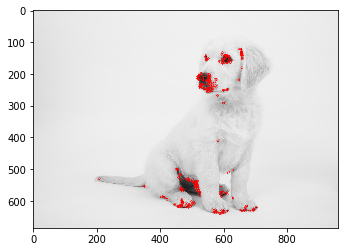

In [3]:
# Feature Detection(Extraction)
# BRISK algorithm 적용
brisk = cv2.BRISK_create()

# keypoints와 각 keypoints에 해당하는 description 생성
keys, desc = brisk.detectAndCompute(gray, None)

print('Number of Keypoints : {}'.format(len(keys)))
print('Shape of descriptions : {}'.format(desc.shape))

# keypoints 그리기(feature)
img2 = cv2.drawKeypoints(gray, keys, None, color = (255, 0, 0))
plt.imshow(img2, cmap = 'gray')

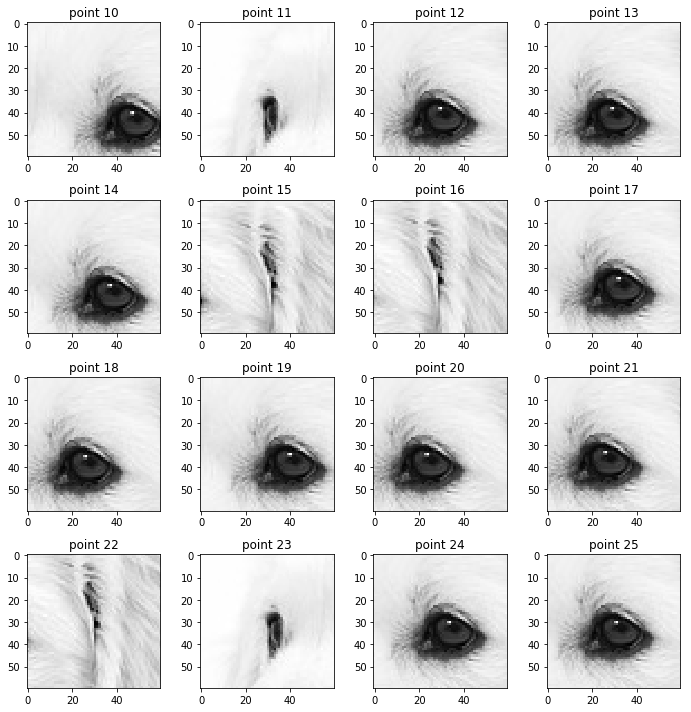

In [4]:
# Visual words 시각화
# Keypoints 결과는 위에서부터 순서대로
def crop_image(img, center, w, h):
    x = int(center[0])
    y = int(center[1])
    img_crop = img[y-w:y+w, x-h:x+h]
    return img_crop

points = cv2.KeyPoint_convert(keys)

plt.figure(figsize = (10,10))
for i in range(16):
    img_crop = crop_image(gray, points[i+10], 30, 30)
    plt.subplot(4,4,i+1)
    plt.title('point {}'.format(i+10))
    plt.imshow(img_crop, cmap = 'gray')
    plt.tight_layout()

In [5]:
# Clustering 실시
# Description에 적용
# Codebook 생성 == Centers of Description
kmeans = KMeans(n_clusters = 10)
kmeans.fit(desc)

data1 = {'Desc' : desc.tolist(), 'Codebook' : kmeans.labels_}
data2 = {'Codebook' : list(set(kmeans.labels_)), 'Center' : kmeans.cluster_centers_.tolist()}
df_kmeans = pd.DataFrame(data1)
df_center = pd.DataFrame(data2)
df_merge = pd.merge(df_kmeans, df_center, how = 'left', on = 'Codebook')

print('Labels of KMeans model :',set(kmeans.labels_))
print('Centers of Description Shape: ', kmeans.cluster_centers_.shape)
df_merge.head(10)

Labels of KMeans model : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Centers of Description Shape:  (10, 64)


,Desc,Codebook,Center
0,"[107, 135, 190, 255, 255, 191, 159, 207, 30, 3...",0,"[167.78571428571428, 173.42857142857144, 160.8..."
1,"[223, 255, 103, 48, 16, 32, 192, 225, 231, 195...",3,"[181.44444444444446, 160.85185185185188, 202.4..."
2,"[254, 143, 65, 48, 44, 64, 0, 128, 225, 231, 1...",7,"[245.22222222222223, 191.99999999999997, 157.7..."
3,"[255, 191, 227, 112, 124, 236, 128, 128, 195, ...",7,"[245.22222222222223, 191.99999999999997, 157.7..."
4,"[248, 255, 255, 243, 97, 192, 0, 3, 0, 0, 30, ...",9,"[235.55223880597012, 243.40298507462688, 247.1..."
5,"[254, 157, 255, 255, 255, 227, 128, 131, 255, ...",3,"[181.44444444444446, 160.85185185185188, 202.4..."
6,"[248, 191, 255, 127, 64, 224, 192, 115, 2, 71,...",6,"[211.0625, 208.4375, 196.71875, 147.84375, 134..."
7,"[252, 255, 255, 255, 243, 227, 0, 0, 128, 130,...",4,"[226.84722222222217, 241.19444444444443, 248.2..."
8,"[180, 253, 255, 255, 243, 67, 128, 239, 255, 2...",8,"[175.2972972972973, 250.5135135135135, 245.513..."
9,"[235, 191, 255, 81, 80, 240, 225, 247, 103, 5,...",1,"[164.05882352941174, 239.70588235294116, 195.2..."


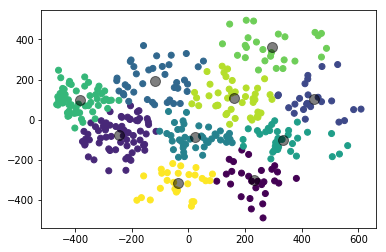

In [6]:
# Visualization 
# 2차원으로 축소한 후 시각화
pca = PCA(n_components=2).fit_transform(desc)
kmeans.fit_predict(pca)

df = pd.DataFrame(pca, columns = ['x', 'y'])
df['cluster'] = kmeans.labels_

plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s = 100, alpha = 0.5)

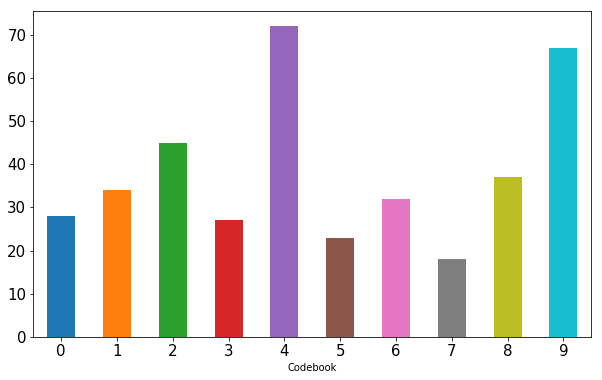

In [7]:
# 각 Codebook별 히스토그램 만들기
df_merge.groupby(['Codebook']).size().plot(kind = 'bar', figsize = (10,6), rot = 0, fontsize=15)

## 강아지 이미지는 위 히스토그램같이 표현할 수 있다.
- 다른 강아지 이미지도 위와 비슷한 경향을 보일 것이다.
- 다른 종류의 이미지는 각 종류별로 다르게 표현될 것이다.

# 모든 이미지 적용
- 보유한 모든 이미지를 이용해 Bag-of-Visual-Words 만들기
- 이미지 종류는 'accordion', 'dollar_bill', 'motorbike', 'soccer_ball'

In [8]:
# 이미지 불러오기
img_path = 'data/image/train/'
class_name = ['accordion', 'dollar_bill', 'motorbike', 'soccer_ball']

def read_img(class_n):
    img_p = img_path + class_n
    img_list = glob.glob(img_p + '/*')
    images = []
    for i in img_list:
        img = cv2.imread(i)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images.append(gray)
        
    return images

acc_img = read_img(class_name[0])
dol_img = read_img(class_name[1])
mot_img = read_img(class_name[2])
sco_img = read_img(class_name[3])

img_list = [acc_img, dol_img, mot_img, sco_img]
for i in img_list:
    print(len(i))

14
14
14
14


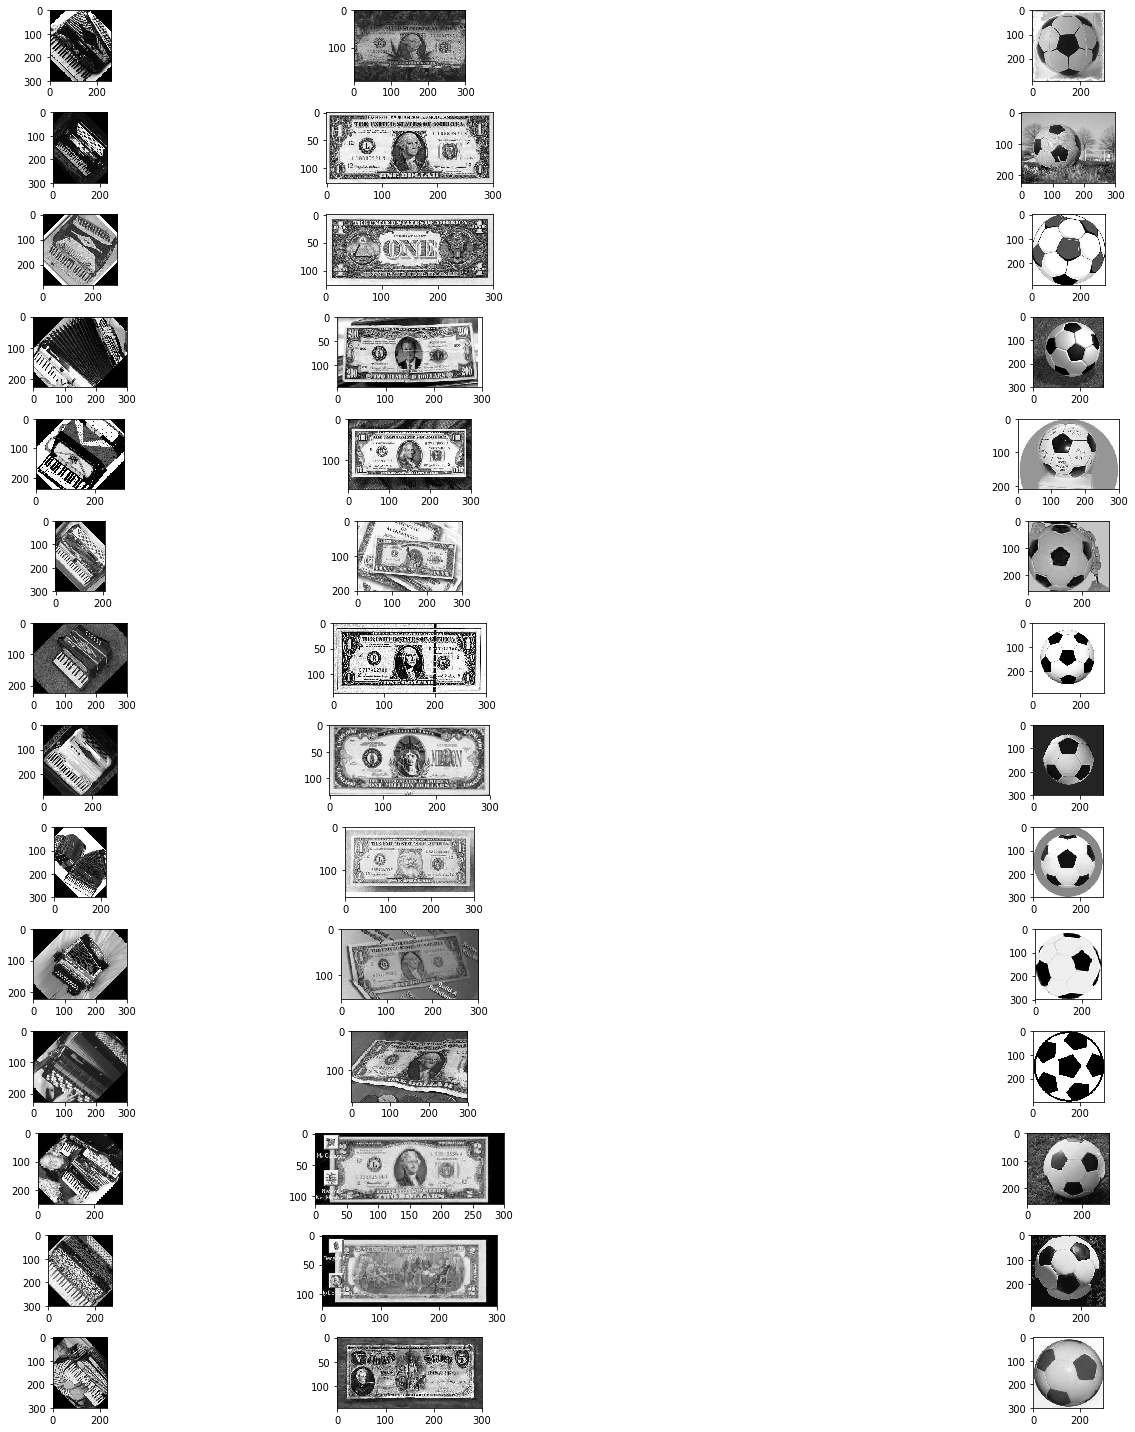

In [9]:
# 이미지 시각화
plt.figure(figsize = (20,20))
for i, img in enumerate(img_list):
    for j, im in enumerate(img):
        plt.subplot(14,4,(4*j+i+1))
        plt.imshow(im, cmap = 'gray')
        plt.tight_layout()

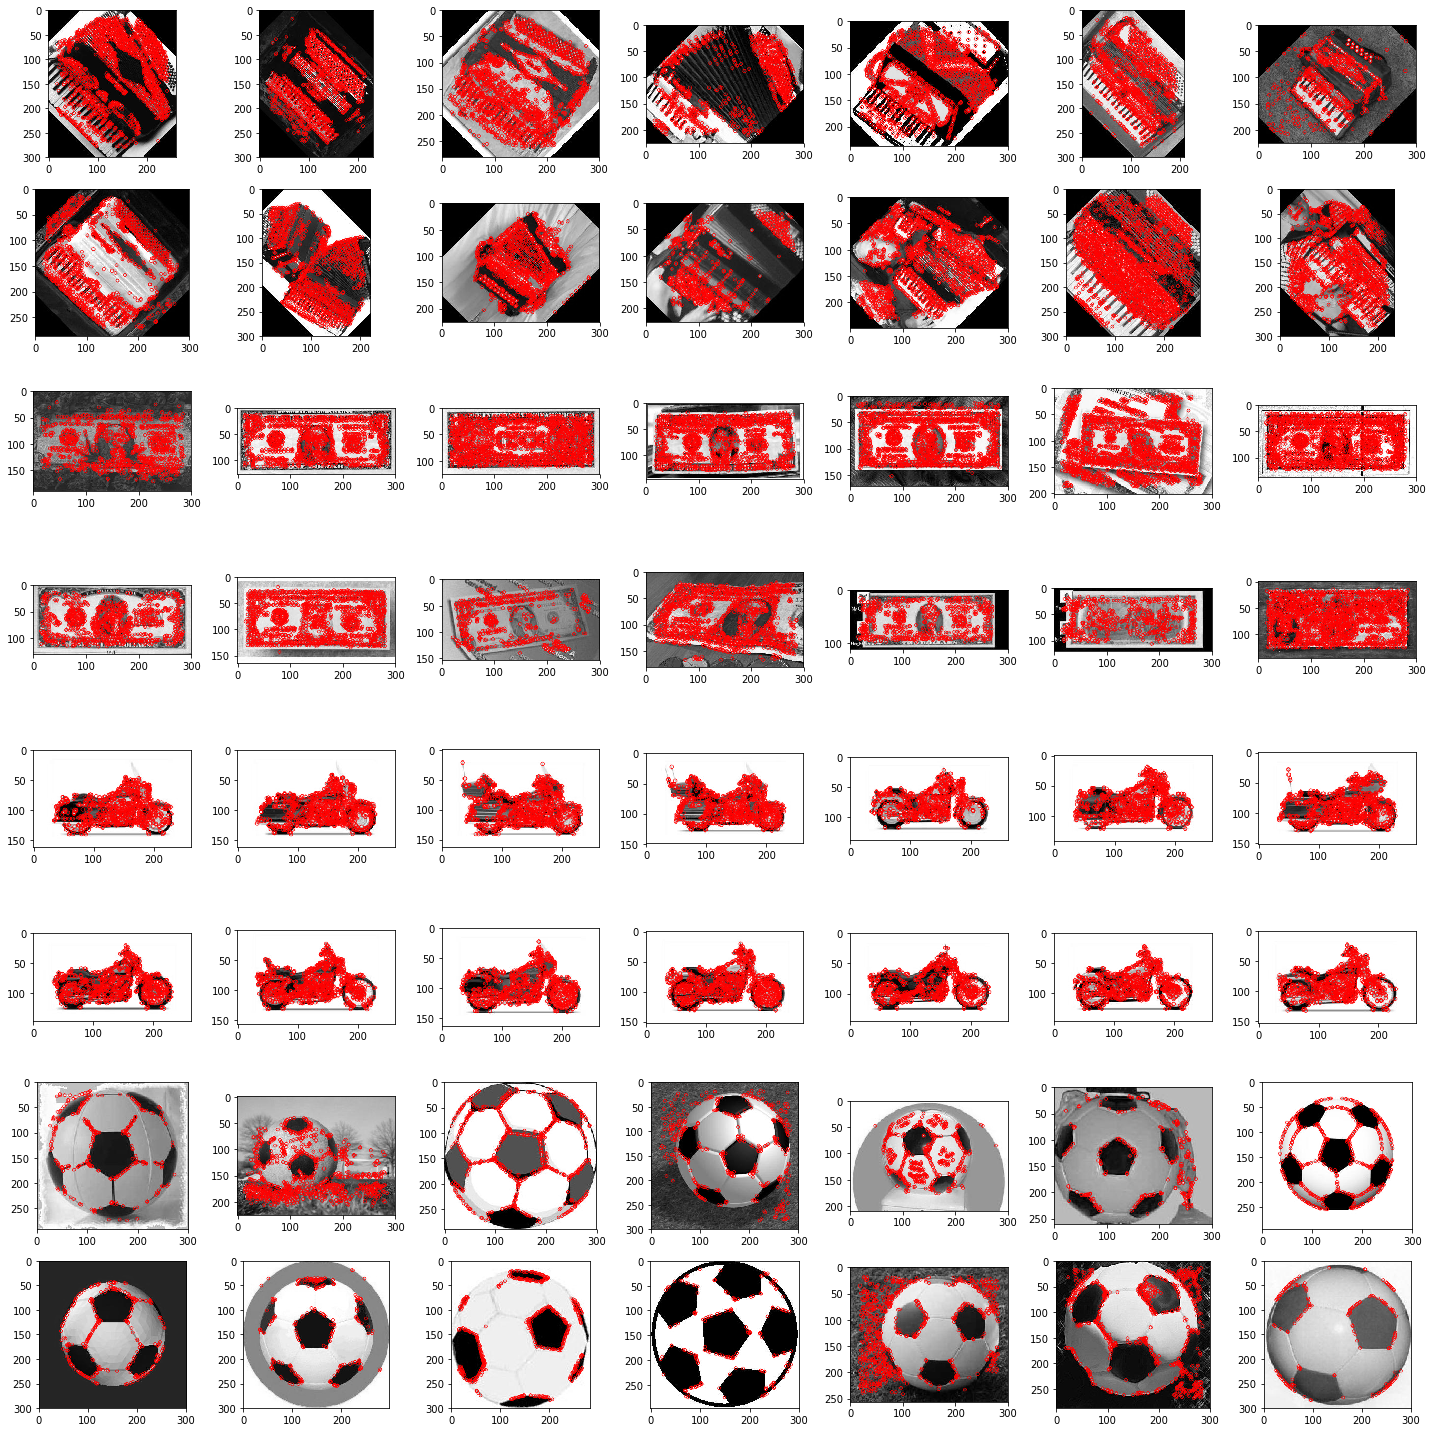

In [10]:
# Feature Detection(BRISK)
brisk = cv2.BRISK_create()

i = 1
key_list, desc_list = [], []

plt.figure(figsize = (20,20))
for img in img_list:
    for im in img:
        keys, desc = brisk.detectAndCompute(im, None)
        key_list.append(keys)
        desc_list.append(desc)
        img_key = cv2.drawKeypoints(im, keys, None, color = (255, 0, 0))
        plt.subplot(8,7,i)
        plt.imshow(img_key, cmap = 'gray')
        plt.tight_layout()
        i += 1

In [11]:
# Clustering Description
desc_sum = [d for desc in desc_list for d in desc]
print('Number of Description : ', len(desc_sum))
print('Example of Description : ', desc_sum[0])

kmeans = KMeans(n_clusters = 40)
kmeans.fit(desc_sum)

Number of Description :  56220
Example of Description :  [252 255 231  32  96 208  32  83  67   2  12 255 248 255 255 247 223 120
   0  48 239 251 255 159 255 227 119 136 123 102  52 227  31  55 214  24
 198   0 225 198  31  61 254 249  63 239  95 254 111   1   0  48  25  12
  39   2  17 244 251  25  76   0 128 163]


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
data = {'Desc' : desc_sum, 'Codebook' : kmeans.labels_}
df_kmeans = pd.DataFrame(data)

print('Labels of KMeans model : ', set(kmeans.labels_))
print('Center of Description Shape : ', kmeans.cluster_centers_.shape)
df_kmeans.head(10)

Labels of KMeans model :  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
Center of Description Shape :  (40, 64)


,Desc,Codebook
0,"[252, 255, 231, 32, 96, 208, 32, 83, 67, 2, 12...",26
1,"[33, 119, 130, 73, 0, 128, 104, 114, 98, 204, ...",4
2,"[188, 129, 95, 4, 240, 223, 180, 91, 0, 0, 0, ...",5
3,"[223, 135, 247, 181, 242, 255, 189, 23, 0, 0, ...",37
4,"[32, 19, 150, 192, 202, 26, 0, 70, 86, 64, 0, ...",31
5,"[196, 255, 255, 243, 129, 0, 0, 229, 239, 223,...",35
6,"[176, 255, 255, 227, 224, 0, 0, 66, 64, 196, 2...",13
7,"[32, 123, 223, 231, 225, 145, 1, 78, 78, 12, 8...",27
8,"[223, 174, 97, 184, 190, 110, 128, 245, 65, 23...",26
9,"[255, 157, 225, 62, 20, 96, 200, 161, 33, 195,...",38


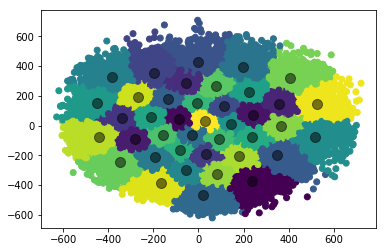

In [20]:
# Visualization 
# 2차원으로 축소한 후 시각화
pca = PCA(n_components=2).fit_transform(desc_sum)
kmeans.fit_predict(pca)

df = pd.DataFrame(pca, columns = ['x', 'y'])
df['cluster'] = kmeans.labels_

plt.scatter(pca[:,0], pca[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s = 100, alpha = 0.5)